# Character-level Recurrent Neural Networs


We will be building and training a basic character-level RNN to classify
words. The model receives a series of characters as input and returns a prediction of the next character together with the `hidden state` at each step. The `hidden step` will be fed onto the next step. At the end the model returns the category (language) a given word belongs to.

The dataset consists of surnames from 18 different languages and returns the language of a given surname. While pytorch has a set of NLP pre-processing functionalities lying on the library `torchtext`, this notebook builds from scratch all the desired functionallity.

#### Import Libraries


In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn

c:\Users\Lukas\anaconda3\envs\hslu-artifin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### General settings

In [3]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
n_hidden = 128 # embedding dimensionality - see slides Recurrent Neural Networks: 62
learning_rate = 0.005 # initial learning rate

nb_epochs = 200000 # number of iterations
print_every = 5000
plot_every = 1000

### Preparing the Data

The original data can be found under the following [link](https://download.pytorch.org/tutorial/data.zip>). You have to download it and unzip on your local directory. The dataset will include 18 different file named as "[Language].txt". Each of these files contains a set of common firstnames for the given language. There is a firstname per line and most of them are romanized, however, some of them might need convertion from Unicode to ASCII.

Based on these files, we will create a dictionary consisting of lists of name per language ``{language: [names ...]}``.


In [5]:
# only needed for google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [6]:
# only if data is not yet extracted & on google drive
# !unzip -q /content/drive/MyDrive/teaching/jupyter/hslu/ai/08_nlp/nlp_data.zip


In [7]:
# google drive only
# !ls data

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# local only
!dir data

 Volume in drive C has no label.
 Volume Serial Number is 505F-3DE4

 Directory of c:\Users\Lukas\Repo\ITDS_H2022_ARTIFIN\09_nlp\data

22/11/2022  09:39    <DIR>          .
22/11/2022  09:39    <DIR>          ..
22/11/2022  09:39         9'677'000 eng-fra.txt
22/11/2022  09:39    <DIR>          names
               1 File(s)      9'677'000 bytes
               3 Dir(s)  933'163'945'984 bytes free


In [5]:
def findFiles(path): 
  return glob.glob(path)

In [6]:
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [28]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters) #57 - 26 letters + 26 capital letters + 4 special characters
#dimensionality of the one-hot vector for each letter in the alphabet (57)

57


In [8]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [32]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [33]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [34]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [35]:
# Generating the dataset dictionary: {'French': ['Arthur', 'Beaumont', ...], 'German': ['Adolf,', ...] }
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [36]:
# Total number of categories, i.e. languages
n_categories = len(all_categories)
print(n_categories)

18


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [37]:
print(category_lines)

{'Arabic': ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', '

In [38]:
# Showing the first 5 german firstnames
print(category_lines['German'][:5])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']


In [39]:
print(category_lines['German'])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer', 'Adler', 'Adlersflugel', 'Aeschelman', 'Albert', 'Albrecht', 'Aleshire', 'Aleshite', 'Althaus', 'Amsel', 'Andres', 'Armbruster', 'Armbruster', 'Artz', 'Aue', 'Auer', 'Augustin', 'Aust', 'Autenburg', 'Auttenberg', 'Baasch', 'Bach', 'Bachmeier', 'Backer', 'Bader', 'Bahr', 'Bambach', 'Bauer', 'Bauers', 'Baum', 'Baumann', 'Baumbach', 'Baumgartner', 'Baumgartner', 'Baumhauer', 'Bayer', 'Beck', 'Becke', 'Beckenbauer', 'Becker', 'Beckert', 'Behrend', 'Behrends', 'Beitel', 'Beltz', 'Benn', 'Berg', 'Berger', 'Bergfalk', 'Beringer', 'Bernat', 'Best', 'Beutel', 'Beyer', 'Beyersdorf', 'Bieber', 'Biermann', 'Bischoffs', 'Blau', 'Blecher', 'Bleier', 'Blumenthal', 'Blumstein', 'Bocker', 'Boehler', 'Boer', 'Boesch', 'Bohler', 'Bohm', 'Bohme', 'Bohmer', 'Bohn', 'Borchard', 'Bosch', 'Bosch', 'Bottcher', 'Brahms', 'Brand', 'Brandt', 'Brant', 'Brauer', 'Braun', 'Braune', 'Breiner', 'Breisacher', 'Breitba

#### Turning Names into Tensors


Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [40]:
# Find letter index from all_letters, e.g. "a"=0,"b"= 1, "c"=2
def letterToIndex(letter):
    return all_letters.find(letter)

In [18]:
# Mapping a letter onto its one-hot encoding: <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters) #initialize a 1x57 tensor with zeros
    tensor[0][letterToIndex(letter)] = 1 #set the index of the letter to 1
    return tensor 

In [19]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) #initialize a line_length x 1 x 57 tensor with zeros
    for li, letter in enumerate(line): #enumerate over the letters in the line
        tensor[li][0][letterToIndex(letter)] = 1 #set the index of the letter to 1
    return tensor

In [41]:
print(letterToTensor('E'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [21]:
lineToTensor('Eckstein') # 9x1x57

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [22]:
print(lineToTensor('Eckstein').size())

torch.Size([8, 1, 57])


### Model

In this section, you have to implement a RNN. As a reference, we will be using the Figure below. Note that, the input $x_{t}$ is first concatenated together with the current hidden state $h_{t}$. Afterwards, a weight matrix $W_{h}$ is applied over the concatenated feature to obtain the new hidden state $h_{t+1}$ and a non-linear $\text{tanh}(\,)$ follows. The new hidden state is fed onto a second layer $W_{o}$ so as to obtain the final model predictions using a $\text{softmax}(\,)$ function.


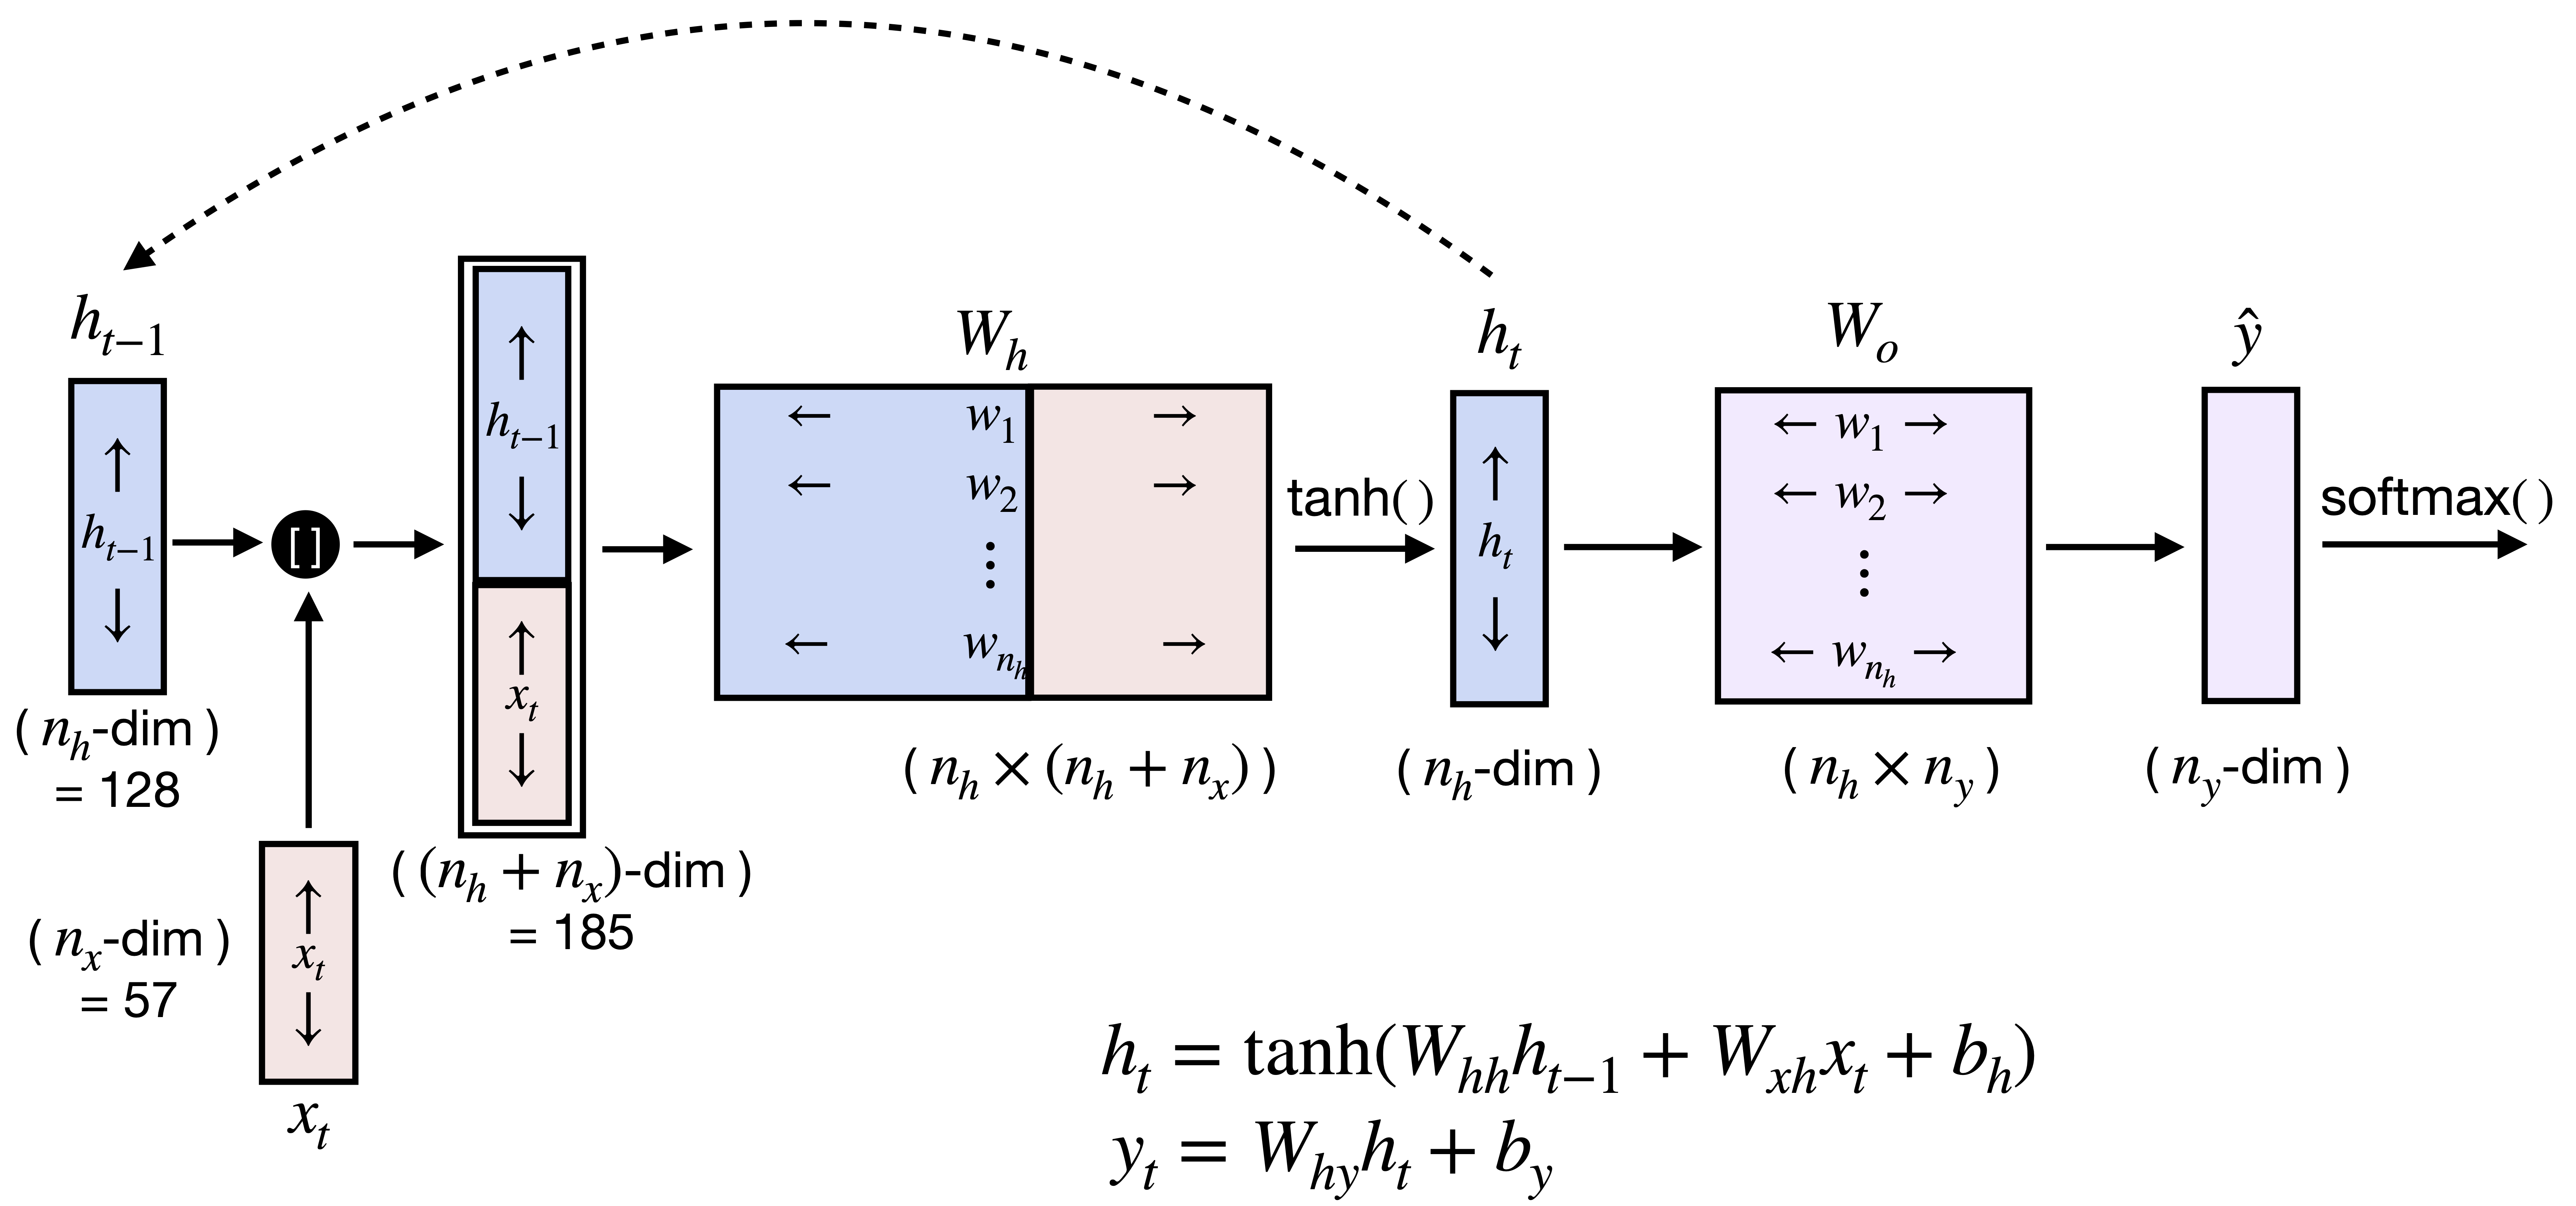

In [43]:
class RNN(nn.Module): #see slides Recurrent Neural Networks: 62
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size #embedding dimensionality 

        ## nn.Linear is used for creating a fully connected layer with the given input and output size
        self.Wh = nn.Linear(input_size+hidden_size, hidden_size) #input_size + hidden_size = 57 + 128 = 185
        self.Wo = nn.Linear(hidden_size, output_size) #128x18
        self.softmax = nn.LogSoftmax(dim=1) # SoftMax vs LogSoftmax -> class 6 (Perceptron, Neural Networks, Loss Function)

    def forward(self, x_t, hidden):
        x_cat = torch.cat((x_t, hidden), 1) #concatenate the input and the hidden state
        x_hidden = torch.tanh(self.Wh(x_cat)) #tanh activation function for the hidden state; see picture as to why the tanh activation function is used
        logits = self.Wo(x_hidden) #calculate the logits
        probas = self.softmax(logits) #calculate the probabilities
        return probas, x_hidden # Instantiate the model

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) #initialize the hidden state with zeros

In [44]:
# initialise model
model = RNN(n_letters, n_hidden, n_categories).to(device) 

In [45]:
print(model)

RNN(
  (Wh): Linear(in_features=185, out_features=128, bias=True)
  (Wo): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [49]:
input = letterToTensor('A').to(device) #input is a 1x57 tensor
hidden = torch.zeros(1, n_hidden).to(device) #initialize the hidden state with zeros

output, next_hidden = model(input, hidden) #calculate the output and the next hidden state

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [50]:
input = lineToTensor('Albert').to(device) #input is a 6x1x57 tensor
hidden = torch.zeros(1, n_hidden).to(device) #initialize the hidden state with zeros

output, next_hidden = model(input[0], hidden) #calculate the output and the next hidden state
print(output)

tensor([[-2.9514, -2.8487, -2.9244, -2.9189, -2.9630, -2.8238, -2.9502, -2.8674,
         -2.9418, -2.9210, -2.7798, -2.8961, -2.8599, -2.8438, -2.8804, -2.9551,
         -2.8716, -2.8527]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




### Training






#### Preparing for Training

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:

In [53]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


We will also want a quick way to get a training example (a name and its
language):




In [61]:
# Given a list of elements, selects randomly one single element
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)] #random.randint(a, b) returns a random integer N such that a <= N <= b

# Given a language dictionary, select a language randomly and then select one sample out of the corresponding language samples.
def randomTrainingExample():
    category = randomChoice(all_categories) #select a language randomly
    line = randomChoice(category_lines[category]) #select a name randomly
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) #convert the language to a tensor
    line_tensor = lineToTensor(line) #convert the name to a tensor
    return category, line, category_tensor, line_tensor 

# Print 10 random training samples
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample() #get a random training sample
    print('category =', category, '/ line =', line) #print the language and the name

category = Scottish / line = Young
category = Vietnamese / line = To
category = French / line = Caron
category = Dutch / line = Ophoven
category = Vietnamese / line = Diep
category = Czech / line = Netsch
category = Portuguese / line = Franco
category = Korean / line = Noh
category = Polish / line = Czajka
category = Polish / line = Gorski


#### Loss


Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [62]:
criterion = nn.NLLLoss() #negative log likelihood loss
# use cross entropy loss as loss function if you have used the "normal" softmax activation function instead of LogSoftmax.

#### Optimizer

In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

In [63]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [64]:
def train_one_epoch(category_tensor, word_tensor):
    hidden = model.initHidden() #initialize the hidden state with zeros h_0

    model.zero_grad() #set the gradients to zero

    # forward-propagation
    for t in range(word_tensor.size()[0]):
        # ..., ... = ... # forward propagation
        output, hidden = model(word_tensor[t], hidden) #calculate the output and the next hidden state

    # compute cost function
    loss = criterion(output, category_tensor) #calculate the loss (you compare the output vs the real one)

    # compute derivatives
    loss.backward() #backpropagation

    # update model parameters (w = w - eta * gradients)
    optimizer.step() #update the parameters

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [2]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, nb_epochs + 1):
    category, line, category_tensor, word_tensor = randomTrainingExample() # get random training sample
    output, loss = train_one_epoch(category_tensor, word_tensor)# call training
    current_loss += loss # add loss to current loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / nb_epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

NameError: name 'time' is not defined

#### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [1]:
plt.figure()
plt.plot((all_losses))
plt.grid()

NameError: name 'plt' is not defined

#### Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




In [58]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [59]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

In [60]:
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [61]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

C:\Users\lukas\AppData\Local\Temp\ipykernel_27868\2790241398.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\lukas\AppData\Local\Temp\ipykernel_27868\2790241398.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


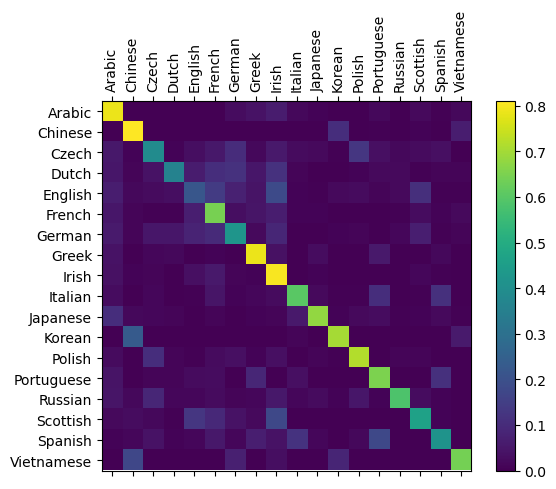

In [62]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




#### Running on User Input




In [63]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [66]:
predict('Bumgarner')


> Bumgarner
(-0.93) German
(-1.80) French
(-1.82) English


In [67]:
predict('Troinitsky')


> Troinitsky
(-0.38) Polish
(-1.97) Russian
(-1.99) Czech


In [69]:
predict('Vargas')


> Vargas
(-0.97) Portuguese
(-1.79) Spanish
(-1.85) French


In [70]:
predict('Brady')


> Brady
(-0.55) Irish
(-1.67) English
(-1.74) Scottish
